In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
%matplotlib inline

## Download Stock Data

In [2]:
import threading

date = '2015-06-15'
ticker_request_case_study = ['TDOC','WD','KNSL','BOMN','APPN']
ticker_request_yahoo_top30 = ['AAPL','MSFT','GOOG','AMZN','FB','TSLA','NVDA','DIS','NVO','AMD','ABNB','GM','NIO','F','RBLX','CRWD','DOCU','BIIB','NOK','AMC','GME','UPST','PSFE','TLRY','BB','PSTH','CLOV','BBBY','MVIS','SAML']
ticker_request_motley_fool_top30 = ['BTC','CMPS','CSTL','CURI','DCBO','GSHD','OM','UPST','CALT','DAVA','FLGT','FTHM','LMND','PUBM','SPT','TTCF','AVIR','BIGC','CELH','DOCN','FVRR','INMD','RETA','SMLR','YALA','AMWL','BTRS','DMTK','FROG','KOD','PGNY','POSH','SKLZ','RWM','VINP']
tickers = []
stocks = {}

def downloadStocks(ticker, date):
    try:
        stocks[ticker] = pdr.get_data_yahoo(ticker,date)
        stocks[ticker].drop('Adj Close', axis=1, inplace=True)
        stocks[ticker].drop('High', axis=1, inplace=True)
        stocks[ticker].drop('Low', axis=1, inplace=True)
        stocks[ticker].drop('Open', axis=1, inplace=True)
        stocks[ticker].drop('Volume', axis=1, inplace=True)
        tickers.append(ticker)
        print("Retrieved %s" % ticker)
    except:
        print("Failed to get %s" % ticker)

threads = []

for ticker in ticker_request_case_study:
    ticker_thread = threading.Thread(target=downloadStocks, args=(ticker, date,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

print(tickers)
stocks[tickers[0]].head()

Retrieved BOMN
Retrieved APPN
Retrieved TDOC
Retrieved WD
Retrieved KNSL
['BOMN', 'APPN', 'TDOC', 'WD', 'KNSL']


,Close
Date,
2017-06-13,22.00
2017-06-14,22.00
2017-06-15,22.00
2017-06-16,13.20
2017-06-19,13.56


## Generate Baseline Performance and Moving Average (MA) Performance

In [3]:
def generateSystems(ticker):
    stocks[ticker]['3-day'] = stocks[ticker]['Close'].rolling(3).mean()
    stocks[ticker]['9-day'] = stocks[ticker]['Close'].rolling(9).mean()
    stocks[ticker]['21-day'] = stocks[ticker]['Close'].rolling(21).mean()
    stocks[ticker]['Change'] = np.log(stocks[ticker].Close / stocks[ticker].Close.shift())
    
    # When the faster moving average is moving above the slower one, indicates time to buy
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] > stocks[ticker]['9-day'], 1,0)
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] > stocks[ticker]['21-day'], 1,0)
    # When the faster moving average is moving below the slower one, indicates time to sell
    stocks[ticker]['position-3-9'] = np.where(stocks[ticker]['3-day'] < stocks[ticker]['9-day'],-1,stocks[ticker]['position-3-9'])
    stocks[ticker]['position-9-21'] = np.where(stocks[ticker]['9-day'] < stocks[ticker]['21-day'],-1,stocks[ticker]['position-9-21'])
    
    # Whether we are making money with this system
    stocks[ticker]['system-3-9'] = np.where(stocks[ticker]['position-3-9'] > 0, stocks[ticker]['position-3-9']* stocks[ticker]['Change'],0)
    stocks[ticker]['system-9-21'] = np.where(stocks[ticker]['position-9-21'] > 0, stocks[ticker]['position-9-21']* stocks[ticker]['Change'],0)

    stocks[ticker]['Volatility'] = stocks[ticker].Change.rolling(21).std().shift()
    
threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility
Date,,,,,,,,,,
2021-05-28,30.660000,30.029999,28.673333,27.750952,0.028451,1,1,0.028451,0.028451,0.023716
2021-06-01,31.590000,30.683333,29.150000,27.920952,0.029882,1,1,0.029882,0.029882,0.024340
2021-06-02,30.490000,30.913333,29.528889,28.021428,-0.035442,1,1,-0.035442,-0.035442,0.024910
2021-06-03,30.559999,30.880000,29.808889,28.166666,0.002293,1,1,0.002293,0.002293,0.026404
2021-06-04,30.700001,30.583333,30.087777,28.317143,0.004571,1,1,0.004571,0.004571,0.025197


## Generate DGIM MA Performance

In [4]:
%reload_ext autoreload
%autoreload 2
from ipynb.fs.full.DGIMMovingAverage import *
import threading

bit_depth = 16
num_buckets = 5

def generateDGIMSystems(ticker):
    stocks_list = stocks[ticker]['Close'].tolist()
    stocks_3day_list = stocks[ticker]['3-day'].tolist()
    stocks_9day_list = stocks[ticker]['9-day'].tolist()
    stocks_21day_list = stocks[ticker]['21-day'].tolist()
    stocks_list_bin = [ np.array(list(np.binary_repr(round(elem)).zfill(bit_depth))).astype(np.int8) for elem in stocks_list ]

    try:
        dgim_3day = DGIMMovingAverage(stocks_list_bin, 3, num_buckets, bit_depth, stocks_3day_list, True)
        stocks[ticker]['3-day-dgim'] = dgim_3day.mov_avg
        dgim_9day = DGIMMovingAverage(stocks_list_bin, 9, num_buckets, bit_depth, stocks_9day_list, True)
        stocks[ticker]['9-day-dgim'] = dgim_9day.mov_avg
        dgim_21day = DGIMMovingAverage(stocks_list_bin, 21, num_buckets, bit_depth, stocks_21day_list, True)
        stocks[ticker]['21-day-dgim'] = dgim_21day.mov_avg

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] > stocks[ticker]['9-day-dgim'], 1,0)
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] > stocks[ticker]['21-day-dgim'], 1,0)

        # When the faster moving average is moving below the slower one, indicates time to sell\
        stocks[ticker]['position-dgim-3-9'] = np.where(stocks[ticker]['3-day-dgim'] < stocks[ticker]['9-day-dgim'],-1,stocks[ticker]['position-dgim-3-9'])
        stocks[ticker]['position-dgim-9-21'] = np.where(stocks[ticker]['9-day-dgim'] < stocks[ticker]['21-day-dgim'],-1,stocks[ticker]['position-dgim-9-21'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9'] = np.where(stocks[ticker]['position-dgim-3-9'] > 0, stocks[ticker]['position-dgim-3-9']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21'] = np.where(stocks[ticker]['position-dgim-9-21'] > 0, stocks[ticker]['position-dgim-9-21']* stocks[ticker]['Change'],0)
        
        print("Finished %s" % ticker)
    except Exception as e:
        print("Failed to analyze %s" % ticker, e)
        tickers.remove(ticker)

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=generateDGIMSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

Finished BOMN
Finished APPN
Finished KNSL
Finished TDOC
Finished WD


## Generate Normalized DGIM MA Performance

In [5]:
def normalizeDGIM(ticker):
    try:
        stocks[ticker]['3-day-dgim-norm']=(stocks[ticker]['3-day-dgim']-stocks[ticker]['3-day-dgim'].mean())/stocks[ticker]['3-day-dgim'].std()
        stocks[ticker]['9-day-dgim-norm']=(stocks[ticker]['9-day-dgim']-stocks[ticker]['9-day-dgim'].mean())/stocks[ticker]['9-day-dgim'].std()
        stocks[ticker]['21-day-dgim-norm']=(stocks[ticker]['21-day-dgim']-stocks[ticker]['21-day-dgim'].mean())/stocks[ticker]['21-day-dgim'].std()

        # When the faster moving average is moving above the slower one, indicates time to buy
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] > stocks[ticker]['9-day-dgim-norm'], 1,0)
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] > stocks[ticker]['21-day-dgim-norm'], 1,0)
        # When the faster moving average is moving below the slower one, indicates time to sell
        stocks[ticker]['position-dgim-3-9-norm'] = np.where(stocks[ticker]['3-day-dgim-norm'] < stocks[ticker]['9-day-dgim-norm'],-1,stocks[ticker]['position-dgim-3-9-norm'])
        stocks[ticker]['position-dgim-9-21-norm'] = np.where(stocks[ticker]['9-day-dgim-norm'] < stocks[ticker]['21-day-dgim-norm'],-1,stocks[ticker]['position-dgim-9-21-norm'])

        # Whether we are making money with this system
        stocks[ticker]['system-dgim-3-9-norm'] = np.where(stocks[ticker]['position-dgim-3-9-norm'] > 0, stocks[ticker]['position-dgim-3-9-norm']* stocks[ticker]['Change'],0)
        stocks[ticker]['system-dgim-9-21-norm'] = np.where(stocks[ticker]['position-dgim-9-21-norm'] > 0, stocks[ticker]['position-dgim-9-21-norm']* stocks[ticker]['Change'],0)
    except:
        pass

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=normalizeDGIM, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()
    
stocks[tickers[0]].tail()

,Close,3-day,9-day,21-day,Change,position-3-9,position-9-21,system-3-9,system-9-21,Volatility,...,position-dgim-9-21,system-dgim-3-9,system-dgim-9-21,3-day-dgim-norm,9-day-dgim-norm,21-day-dgim-norm,position-dgim-3-9-norm,position-dgim-9-21-norm,system-dgim-3-9-norm,system-dgim-9-21-norm
Date,,,,,,,,,,,,,,,,,,,,,
2021-05-28,30.660000,30.029999,28.673333,27.750952,0.028451,1,1,0.028451,0.028451,0.023716,...,-1,0.000000,0.000000,1.142091,1.092052,1.050589,1,1,0.028451,0.028451
2021-06-01,31.590000,30.683333,29.150000,27.920952,0.029882,1,1,0.029882,0.029882,0.024340,...,-1,0.029882,0.000000,3.641430,1.217263,1.093178,1,1,0.029882,0.029882
2021-06-02,30.490000,30.913333,29.528889,28.021428,-0.035442,1,1,-0.035442,-0.035442,0.024910,...,1,-0.035442,-0.035442,3.641430,1.317433,1.114472,1,1,-0.035442,-0.035442
2021-06-03,30.559999,30.880000,29.808889,28.166666,0.002293,1,1,0.002293,0.002293,0.026404,...,1,0.002293,0.002293,3.641430,1.367517,1.146414,1,1,0.002293,0.002293
2021-06-04,30.700001,30.583333,30.087777,28.317143,0.004571,1,1,0.004571,0.004571,0.025197,...,1,0.000000,0.004571,1.220195,1.442644,1.178355,-1,1,0.000000,0.004571


## View Individual Stocks DGIM/Normalized DGIM MA vs. Baseline and MA Performance

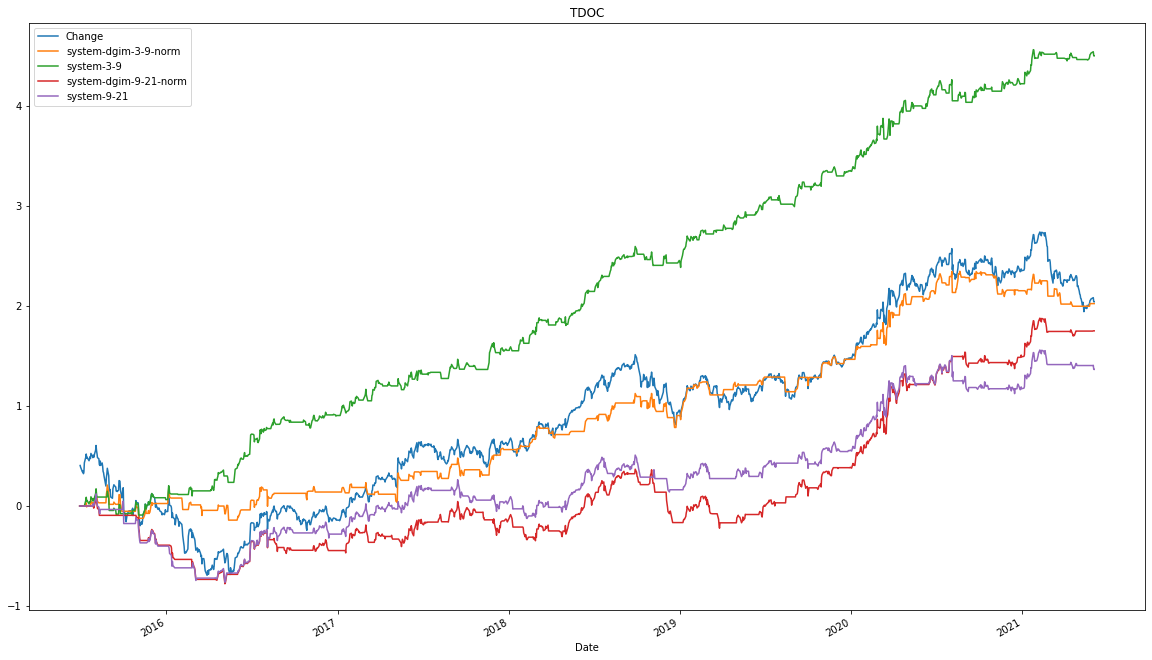

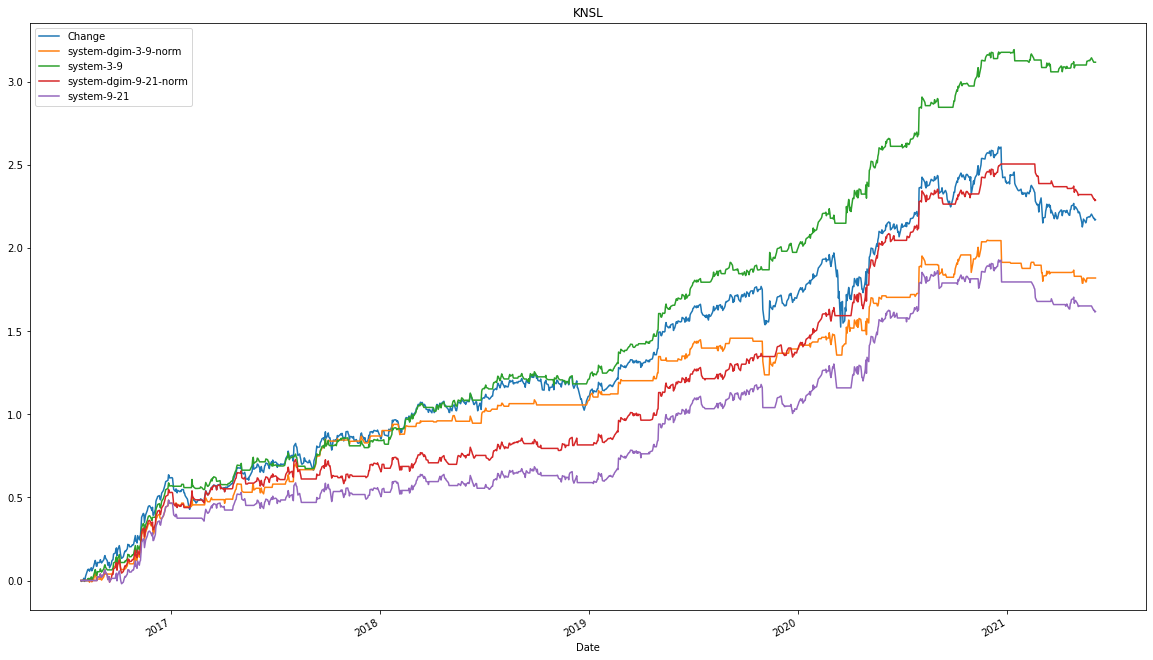

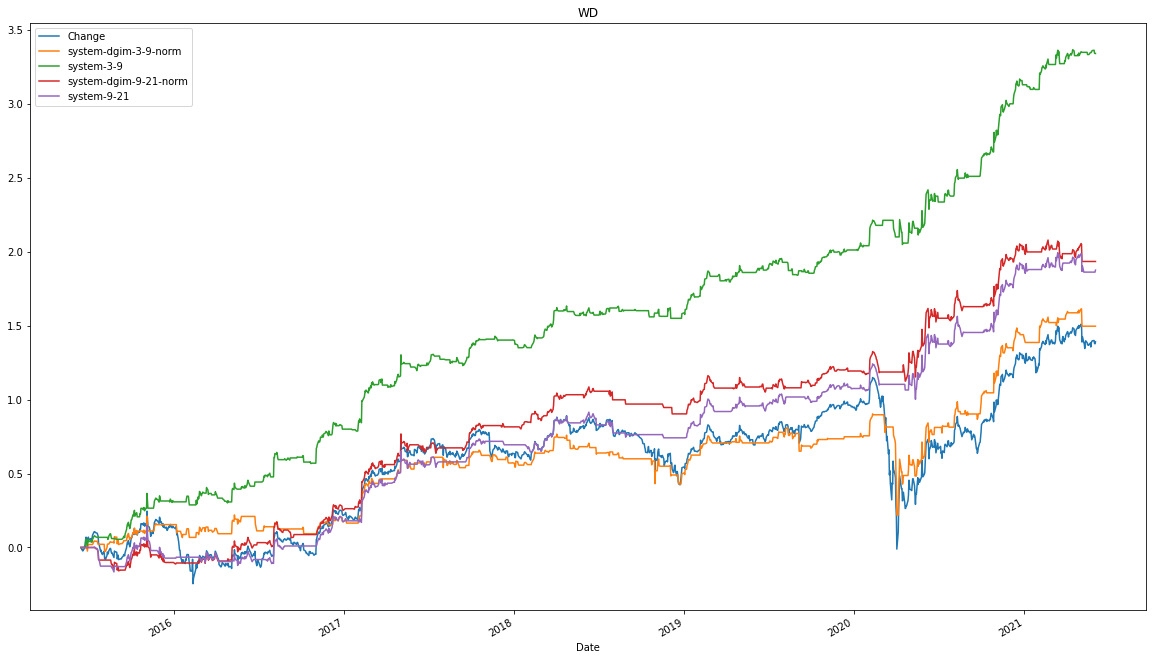

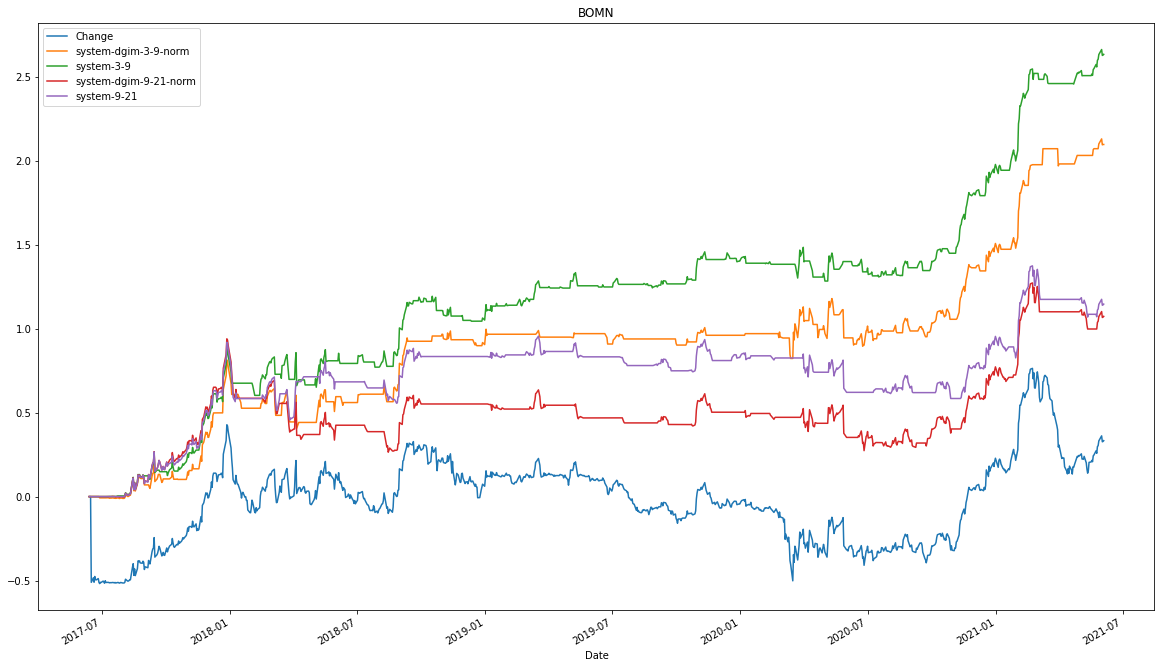

In [6]:
def printSystems(ticker):
    stocks[ticker][['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().plot(title=ticker,figsize=(20,12))

threads = []

for ticker in tickers:
    ticker_thread = threading.Thread(target=printSystems, args=(ticker,))
    ticker_thread.start()
    threads.append(ticker_thread)

for t in threads:
    t.join()

## View Accumulated Performance

,Change,system-dgim-3-9-norm,system-3-9,system-dgim-9-21-norm,system-9-21
2021-06-03,7.512621,10.35124,17.469774,9.292922,8.001413
2021-06-04,7.528786,10.35124,17.469273,9.295719,8.017579
2021-06-05,7.528786,10.35124,17.469273,9.295719,8.017579
2021-06-06,7.528786,10.35124,17.469273,9.295719,8.017579
2021-06-07,7.528786,10.35124,17.469273,9.295719,8.017579


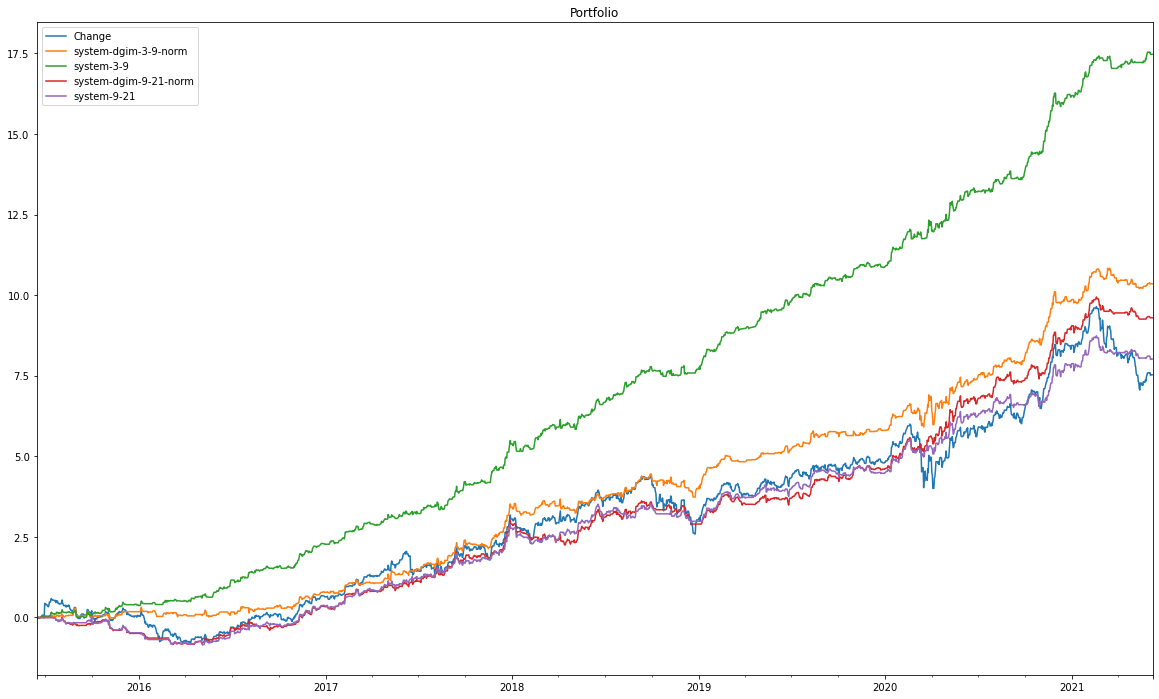

In [7]:
portfolio = 0
for ticker in tickers:
    idx = pd.date_range(date, pd.to_datetime('today'))
    portfolio += stocks[ticker].reindex(idx, fill_value=0)

portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().fillna(method ='pad').plot(title="Portfolio",figsize=(20,12))
portfolio[['Change','system-dgim-3-9-norm','system-3-9','system-dgim-9-21-norm','system-9-21']].cumsum().tail()

## Determine Mean Difference for MA and Normalized DGIM MA Performance against Baseline

In [8]:
analysis = []
for ticker in tickers:
    analysis.append({"gain-3-9": stocks[ticker]['system-3-9'].cumsum().tail(1)[0],
                     "gain-9-21": stocks[ticker]['system-9-21'].cumsum().tail(1)[0],
                     "gain-dgim-3-9-norm": stocks[ticker]['system-dgim-3-9-norm'].cumsum().tail(1)[0],
                     "gain-dgim-9-21-norm": stocks[ticker]['system-dgim-9-21-norm'].cumsum().tail(1)[0],
                     "change": stocks[ticker]['Change'].cumsum().tail(1)[0]})
analysisDf = pd.DataFrame(analysis)

meanDifference_3_9 = (analysisDf['gain-3-9'] - analysisDf['change']).mean()
meanDifference_9_21 = (analysisDf['gain-9-21'] - analysisDf['change']).mean()
meanDifference_dgim_3_9_norm = (analysisDf['gain-dgim-3-9-norm'] - analysisDf['change']).mean()
meanDifference_dgim_9_21_norm = (analysisDf['gain-dgim-9-21-norm'] - analysisDf['change']).mean()
print("meanDifference_3_9:",meanDifference_3_9)
print("meanDifference_9_21:", meanDifference_9_21)
print("meanDifference_dgim_3_9_norm:", meanDifference_dgim_3_9_norm)
print("meanDifference_dgim_9_21_norm:", meanDifference_dgim_9_21_norm)

meanDifference_3_9: 1.9458141269110776
meanDifference_9_21: 0.05547515692678569
meanDifference_dgim_3_9_norm: 0.522207530055854
meanDifference_dgim_9_21_norm: 0.31110315090199536
